In [17]:
import os
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import pandas as pd
import preprocessing as prep
from model import perturbation,Predictor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from random import sample

# wl_path = r'D:\20240412\wl.csv'
# select_path = r'D:\20240412\0412mean.csv'

# select = pd.read_csv(select_path,header=None).values
# raw_wl = pd.read_csv(wl_path,header=None).values.astype(np.float32)[12200-2048:12200]

# mean_spec = select[1:,1:]
# mean_spec = mean_spec[12200-2048:12200,:].T.astype(float)
# mean_lab = select[0,1:].astype(float)
# SKB = SelectKBest(f_regression, k=10)
# select_feat = SKB.fit_transform(mean_spec, mean_lab.ravel())
# index_feat = SKB.get_support()
# np.savetxt(r'D:/20240412/select_wl.csv',np.vstack((raw_wl[index_feat].reshape(-1),np.where(index_feat)[0])).T,delimiter=',',fmt='%s')

path = r'D:\20240412\wei\all.csv'
label_path = r'D:\20240412\alllab.csv'
wl_path = r'D:\20240412\wl.csv'
save_path = r'D:\20240412\wei\bpnn'

# super iter
num_feat = 10
random_seed = 2024  
batch_size = 128
lr = 3e-4
num_epochs = 1000
step_epoch = 10
new_feat_size = 300
mean_times = 50
new_feat = []
new_lab = []

######### read raw data ####################

raw_feat = pd.read_csv(path,header=None).values.astype(np.float32)[:,12195-2048:12195]
raw_label = pd.read_csv(label_path,header=None).values.astype(np.float32)
raw_wl = pd.read_csv(wl_path,header=None).values.astype(np.float32)[12201-2048:12201]




######### make new feat ####################

unique_lab = np.unique(raw_label)
for labs in unique_lab:
    index = np.isin(raw_label,labs).reshape(-1)
    unique_feat = raw_feat[index,:]
    for _ in range(new_feat_size):
        new_feat.append(np.mean(unique_feat[ sample(range(0,len(unique_feat[:,0]-1)),mean_times),:],axis = 0))
        new_lab.append(labs)

new_feat = np.array(new_feat)
new_lab = np.array(new_lab).reshape(-1,1)

# 取测试集
unique_lab = np.unique(new_lab)
select_lab = unique_lab[3]

In [18]:

test_index = np.isin(new_lab,select_lab).reshape(-1)#-600 500 -1 50 

# # normalization
# feat_scaler = MinMaxScaler()
# lab_scaler = MinMaxScaler()

# for spec in range(len(new_feat[:,0])):
#     norm_feat.append(prep.Normalization(new_feat[spec,:]) )
# norm_feat = np.array(norm_feat) * 1000
norm_feat = new_feat * 1000
# norm_lab = lab_scaler.fit_transform(raw_label)

#buyong scaler

test_feat = norm_feat[test_index,:]
test_label = new_lab[test_index]
train_feat = norm_feat[~test_index,:]
train_label = new_lab[~test_index]

# random seeding

np.random.seed(random_seed)  
random_index = [i for i in range(len(train_label))]
np.random.shuffle(random_index)

train_feat = train_feat[random_index,:]
train_label = train_label[random_index]


# # import select
index_feat = pd.read_csv(r'D:\20240412\select_wl.csv',header=None).values[:,1].astype(int)


train_feat = train_feat[:, index_feat]
test_feat = test_feat[:, index_feat]

select_wl = raw_wl[index_feat]

# split train and test
# x_train,x_test,y_train,y_test = train_test_split(
#     norm_feat,norm_lab, test_size=0.2,shuffle = False)

x_train,x_test,y_train,y_test = train_feat,test_feat,train_label,test_label

train_data = torch.tensor(x_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32)
train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_label), batch_size=100, shuffle=True)

test_data = torch.tensor(x_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.float32)
test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_data, test_label), batch_size=100, shuffle=True)
'''remember to set shuffle to False'''

# parameter define

if torch.cuda.is_available():
    device = 'cuda'
    print("Using GPU !")
else:
    device = 'cpu'

logdir = os.getcwd()
device = 'cpu'

model = torch.load(r'D:\20240412\wei\bpnn\50.0best_net.pth')
perturb = perturbation(num_feat)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
perturb_optimizer = torch.optim.Adam(perturb.parameters(), lr=5e-4)


Using GPU !


In [19]:
# variable define
all_sigma = []
y_train1 = []
y_test1 = []
y_train2 = []
y_test2 = []
## 模型训练
model.to(device)
model.eval()

with torch.no_grad():
    sum_train_r2 = 0
    sum_test_r2 = 0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        preds = model(x)

        # 评估指标
        # y_denormalized = lab_scaler.inverse_transform(y.cpu())
        # preds_denormalized = lab_scaler.inverse_transform(preds.cpu())
        y_denormalized = y
        preds_denormalized = preds
        sum_train_r2 = sum_train_r2 + r2_score(y_denormalized,preds_denormalized)
        y_train1.append(preds_denormalized.numpy().reshape(-1,1))
        y_train2.append(y_denormalized.numpy().reshape(-1,1))
        # 计算损失
    for x_t, y_t in test_dataloader:
        x_t = x_t.to(device)
        y_t = y_t.to(device)
        preds = model(x_t)

        # 评估指标
        # y_denormalized = lab_scaler.inverse_transform(y_t.cpu())
        # preds_denormalized = lab_scaler.inverse_transform(preds.cpu())
        y_denormalized = y_t
        preds_denormalized = preds

        sum_test_r2 = sum_test_r2 + r2_score(y_denormalized,preds_denormalized)
        y_test1.append(preds_denormalized.numpy().reshape(-1,1))
        y_test2.append(y_denormalized.numpy().reshape(-1,1))
        
    sum_train_r2 = sum_train_r2 / len(train_dataloader) #数据存到cpu= 直接用.item()也行
    sum_test_r2 = sum_test_r2 / len(test_dataloader)

print(sum_train_r2)
print(sum_test_r2)

0.9484822059223917
0.0


In [20]:
# np.savetxt(save_path + '//' + 'Y_predict.csv',
#            np.hstack((np.vstack((np.array(y_train1).reshape(-1,1),np.array(y_test1).reshape(-1,1))),
#                       np.vstack((np.array(y_train2).reshape(-1,1),np.array(y_test2).reshape(-1,1))))),
#            delimiter=',',fmt='%s')

In [21]:
model.cpu()
perturb.cpu()
another_epoch = int(num_epochs/10)

train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_label), batch_size=64, shuffle=False)

for epochs in range(another_epoch):
    loop = tqdm(train_dataloader, total=len(train_dataloader))
    for x, y in loop:
        x = x.cpu()
        pp,pm,sigma = perturb(x)
        sigma = sigma.cpu().detach()#记得换个位置存
        p = model(x)
        pp = model(pp)
        pm = model(pm)
        pp = torch.abs(pp - p)
        pm = torch.abs(pm - p)
        const = torch.full([pp.size()[0],1],torch.max(p).item())
        const_0 = torch.full([pp.size()[0],1],torch.min(p).item())

        l1 = criterion(pp,const_0)
        l2 = criterion(pm,const)
        l3 = criterion(sigma,torch.zeros(num_feat))

        loss = l1 + l2 + l3


        perturb_optimizer.zero_grad()
        loss.backward()
        perturb_optimizer.step()
        loop.set_description('epoch: [%d/%d]' % (epochs, another_epoch))

    if epochs % step_epoch == 0: # 每step_epoch次epoch存一次数据
        save_sigma = sigma.clone().numpy()
        all_sigma.append(save_sigma)
        

epoch: [99/100]: 100%|██████████| 57/57 [00:00<00:00, 273.45it/s]


In [22]:
np.savetxt(save_path + '//' + 'sigma.csv',all_sigma[-1],delimiter=',',fmt='%s')
scaler = MinMaxScaler()
save_sigma = scaler.fit_transform(save_sigma.reshape(-1,1))
np.savetxt(save_path + '//' + 'sigma2.csv',save_sigma,delimiter=',',fmt='%s')

In [23]:
all_sigma

[array([0.628916  , 0.6287201 , 0.6288738 , 0.6158424 , 0.6289867 ,
        0.62824625, 0.6289482 , 0.6180181 , 0.6158367 , 0.62898177],
       dtype=float32),
 array([0.6788532 , 0.6827794 , 0.6910212 , 0.5393538 , 0.69111997,
        0.6831757 , 0.6932646 , 0.578052  , 0.54393995, 0.6915119 ],
       dtype=float32),
 array([0.69909406, 0.7264364 , 0.7443237 , 0.46043152, 0.74258333,
        0.72905743, 0.744601  , 0.5463022 , 0.46982658, 0.7428055 ],
       dtype=float32),
 array([0.7391073 , 0.765826  , 0.7816338 , 0.40492502, 0.7817364 ,
        0.7663969 , 0.7802107 , 0.51324755, 0.41174388, 0.78133243],
       dtype=float32),
 array([0.7926267 , 0.798298  , 0.8090085 , 0.36929905, 0.8122894 ,
        0.7970689 , 0.80548906, 0.47958076, 0.3677855 , 0.8114625 ],
       dtype=float32),
 array([0.8392406 , 0.82553047, 0.8299763 , 0.35316625, 0.83681256,
        0.82219976, 0.8235227 , 0.4471841 , 0.33544534, 0.8357752 ],
       dtype=float32),
 array([0.87267107, 0.8484137 , 0.847354

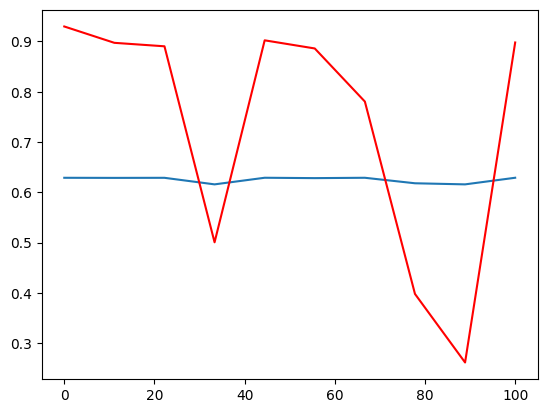

In [24]:
plt.figure(1)
x = np.linspace(0,100,len(all_sigma[0]))
plt.plot(x,all_sigma[0])
plt.plot(x,all_sigma[-1],c = 'r')